# Why Brian2
* Sparse
* can be converted to fast cpp CUDA code and run on Nvidia Nano.


## Time surfaces

* give brian2 an Event based property
* Applied Biological
* Jobs differential equations


I can recommend these materials:
 
Book (free online version) Chapter 2 only:
https://neuronaldynamics.epfl.ch/online/index.html

Exercises based on the book:
https://neuronaldynamics-exercises.readthedocs.io/en/latest/

Tutorials:
https://github.com/brian-team/brian2/tree/master/tutorials
 
Slides only (not the code, or code exercises):
https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html
 
The class tutorial I make will be based on all four sources I think.

![wsu_branding.jpg](wsu_branding.jpg)

![](trees.png)

In [11]:
from brian2 import *
import plotly
from brian2 import NeuronGroup, SpikeMonitor, StateMonitor, run
from brian2.units import ms
import plotly.express as px
import pandas as pd
from ipywidgets import Button, Layout
import ipywidgets
%matplotlib inline
start_scope()





![](water_analogy.png)

# First we will simulate a LIF neuron 
the easy way using Brian2, so we know we have something to compare with


In this tutorial we will.

* solve the LIF neuron using scikit learn

* show it with LIF widget, and LIF plotly. 

Fit LIF to music, with a FB never grad.

* Conceptualize what is necessary to 

On the time-grid of of stepsize $\Delta t$, the dynamics of Eqn. (1) is discretized to be 

\begin{eqnarray}
\tau_m \frac{\Delta V_n}{\Delta t} &=& -(V_n-V_L) +\frac{I_n}{g_L},
\end{eqnarray}

where $V_n = V(n\Delta t)$, and $I_n=I(n\Delta t)$. 

Then the updating process of $V_{n+1}$ at time $t_{n+1}=(n+1)\Delta t$ based on $V_{n}$ can be formed as 

\begin{eqnarray}
V_{n+1} &=& V_n+ \Delta V_n \\
\Delta V_n &=&  \left(-(V_n-V_L) +\frac{I}{g_L}\right)\frac{\Delta t}{\tau_m} \qquad (2)
\end{eqnarray}


WARNING    <ipython-input-58-506dc592240e>:2: NumbaWarning:


Compilation is falling back to object mode WITH looplifting enabled because Function "run_LIF" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-58-506dc592240e> (19)

File "<ipython-input-58-506dc592240e>", line 19:
def run_LIF(pars, Iinj, stop=False):
    <source elided>
  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  ^


 [py.warnings]
WARNING    <ipython-input-58-506dc592240e>:2: NumbaWarning:


Compilation is falling back to object mode WITHOUT looplifting enabled because Function "run_LIF" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-58-506dc592240e>", line 42:
def run_LIF(pars, Iinj, stop=False):
    <source elided>
  #times = [it for it in range(Lt - 2)]
  for it in range(Lt - 2):
  ^


 [py.warnings]
WARNING    /home/user/anaconda3/lib/python3.7/site-packages/numba/c

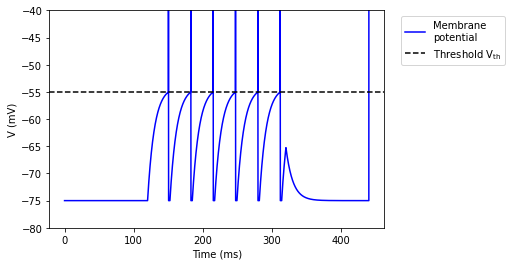

In [58]:
import numba
@numba.jit
def run_LIF(pars, Iinj, stop=False):
  """
  Simulate the LIF dynamics with external input current

  Args:
    pars       : parameter dictionary
    Iinj       : input current [pA]. The injected current here can be a value
                 or an array
    stop       : boolean. If True, use a current pulse

  Returns:
    rec_v      : membrane potential
    rec_sp     : spike times
  """

  # Set parameters
  V_th, V_reset = pars['V_th'], pars['V_reset']
  tau_m, g_L = pars['tau_m'], pars['g_L']
  V_init, E_L = pars['V_init'], pars['E_L']
  dt, range_t = pars['dt'], pars['range_t']
  Lt = range_t.size
  tref = pars['tref']

  # Initialize voltage
  v = np.zeros(Lt)
  v[0] = V_init

  # Set current time course
  Iinj = Iinj * np.ones(Lt)

  # If current pulse, set beginning and end to 0
  if stop:
    Iinj[:int(len(Iinj) / 2) - 1000] = 0
    Iinj[int(len(Iinj) / 2) + 1000:] = 0
  #print(Iinj)
  # Loop over time
  rec_spikes = []  # record spike times
  tr = 0.  # the count for refractory duration
  #times = [it for it in range(Lt - 2)]
  for it in range(Lt - 2):


    if tr > 0:  # check if in refractory period
      v[it] = V_reset  # set voltage to reset
      tr = tr - 1 # reduce running counter of refractory period
    elif v[it] >= V_th:  # if voltage over threshold
      rec_spikes.append(it)  # record spike event
      v[it] = V_reset  # reset voltage

      tr = tref / dt  # set refractory time
    # Calculate the increment of the membrane potential
    dv = (-(v[it]-E_L) + (Iinj[it]/g_L))*(dt/tau_m)
    # Update the membrane potential
    v[it + 1] = v[it] + dv

    ########################################################################
    ## TODO for students: compute the membrane potential v, spike train sp #
    # Fill out function and remove
    #raise NotImplementedError('Student Exercise: calculate the dv/dt and the update step!')
    ########################################################################

    

  # Get spike times in ms
  rec_spikes = np.array(rec_spikes) * dt
    
  return v, rec_spikes#, times

def default_pars(**kwargs):
  pars = {}

  # typical neuron parameters#
  pars['V_th'] = -55.     # spike threshold [mV]
  pars['V_reset'] = -75.  # reset potential [mV]
  pars['tau_m'] = 10.     # membrane time constant [ms]
  pars['g_L'] = 10.       # leak conductance [nS]
  pars['V_init'] = -75.   # initial potential [mV]
  pars['E_L'] = -75.      # leak reversal potential [mV]
  pars['tref'] = 2.       # refractory time (ms)

  # simulation parameters #
  pars['T'] = 440.  # Total duration of simulation [ms]
  pars['dt'] = .1   # Simulation time step [ms]

  # external parameters if any #
  for k in kwargs:
    pars[k] = kwargs[k]

  pars['range_t'] = np.arange(0, pars['T'], pars['dt'])  # Vector of discretized time points [ms]

  return pars


pars = default_pars()

# Get parameters
#pars = default_pars(T=500)

# Simulate LIF model
v, sp = run_LIF(pars, Iinj=210, stop=True)

# Visualize

#def plot_volt_trace(v,times):
#    print(len(v))
#    print(len(times))

#    plotly.express.line(x=times,y=v)

def plot_volt_trace(pars, v, sp):
  """
  Plot trajetory of membrane potential for a single neuron

  Expects:
  pars   : parameter dictionary
  v      : volt trajetory
  sp     : spike train

  Returns:
  figure of the membrane potential trajetory for a single neuron
  """

  V_th = pars['V_th']
  dt, range_t = pars['dt'], pars['range_t']
  if sp.size:
    sp_num = (sp / dt).astype(int) - 1
    v[sp_num] += 20  # draw nicer spikes

  plt.plot(pars['range_t'], v, 'b')
  plt.axhline(V_th, 0, 1, color='k', ls='--')
  plt.xlabel('Time (ms)')
  plt.ylabel('V (mV)')
  plt.legend(['Membrane\npotential', r'Threshold V$_{\mathrm{th}}$'],
             loc=[1.05, 0.75])
  plt.ylim([-80, -40])

plot_volt_trace(pars, v, sp)



In [59]:

my_layout=Layout(width='50%', height='80px')
#my_layout.width = '450px'
@ipywidgets.interact(
    I_dc=ipywidgets.FloatSlider(50., min=0., max=300., step=1.,
                               layout=my_layout),
    tau_m=ipywidgets.FloatSlider(10., min=2., max=20., step=2.,
                                layout=my_layout)
)

def diff_DC(I_dc=200., tau_m=10.):
  pars = default_pars(T=1000.)
  pars['tau_m'] = tau_m
  v, sp = run_LIF(pars, Iinj=I_dc)
  plot_volt_trace(pars, v, sp)
  plt.show()

interactive(children=(FloatSlider(value=50.0, description='I_dc', layout=Layout(height='80px', width='50%'), m…

WARNING    "v" is an internal variable of group "neurongroup_1", but also exists in the run namespace with the value array([-75., -75., -75., ...,   0.,   0.,   0.]). The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


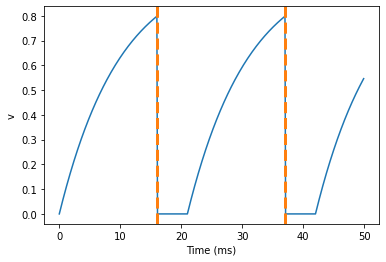

In [42]:
start_scope()

tau = 10*ms
#eqs0 = '''dv/dt = I_leak / Cm : volt
#                       I_leak = g_L*(E_L - v) : amp'''

#G0 = NeuronGroup(1, eqs0, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')


eqs = '''
dv/dt = (1-v)/tau : 1 (unless refractory)
'''

G = NeuronGroup(1, eqs, threshold='v>0.8', reset='v = 0', refractory=5*ms, method='exact')

statemon = StateMonitor(G, 'v', record=0)
spikemon = SpikeMonitor(G)

run(50*ms)

plot(statemon.t/ms, statemon.v[0])
df = pd.DataFrame({'v':statemon.v[0],'t':statemon.t/ms})

#df = px.data.gapminder().query("country=='Canada'")
fig = px.line(df, x="t", y="v")
fig.show()

for t in spikemon.t:
    axvline(t/ms, ls='--', c='C1', lw=3)
xlabel('Time (ms)')
ylabel('v');

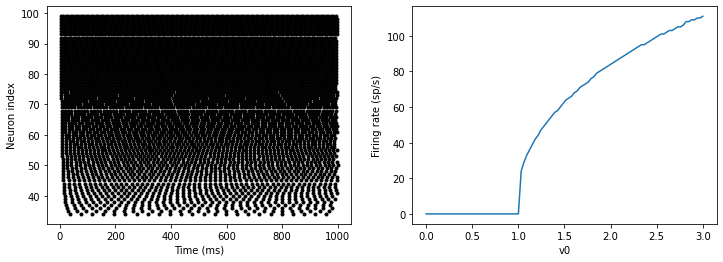

In [13]:
start_scope()


##
# A network of 100 neurons
##
N = 100
tau = 10*ms
v0_max = 3.
duration = 1000*ms

eqs = '''
dv/dt = (v0-v)/tau : 1 (unless refractory)
v0 : 1
'''

G = NeuronGroup(N, eqs, threshold='v>1', reset='v=0', refractory=5*ms, method='exact')
M = SpikeMonitor(G)

G.v0 = 'i*v0_max/(N-1)'

run(duration)

figure(figsize=(12,4))
subplot(121)
plot(M.t/ms, M.i, '.k')
xlabel('Time (ms)')
ylabel('Neuron index')
subplot(122)
plot(G.v0, M.count/duration)
xlabel('v0')
ylabel('Firing rate (sp/s)');

I can recommend these materials:
 
Book (free online version) Chapter 2 only:
https://neuronaldynamics.epfl.ch/online/index.html

Exercises based on the book:
https://neuronaldynamics-exercises.readthedocs.io/en/latest/

Tutorials:
https://github.com/brian-team/brian2/tree/master/tutorials
 
Slides only (not the code, or code exercises):
https://compneuro.neuromatch.io/tutorials/W2D3_BiologicalNeuronModels/student/W2D3_Tutorial1.html
 
The class tutorial I make will be based on all four sources I think.

In [5]:
print("Introspection")
print(dir(brian2))

Introspection


NameError: name 'brian2' is not defined